# Sensitivity Analysis

## Using AutoEmulate

To improve efficiency when running the sensitivity analysis, you can ran the model through an emulator first, to conduct rapid evaluations instead of running continual time-consuming simulations of the original model.

Using the output of the reduced PCA and the parameters sets as input for emulation.

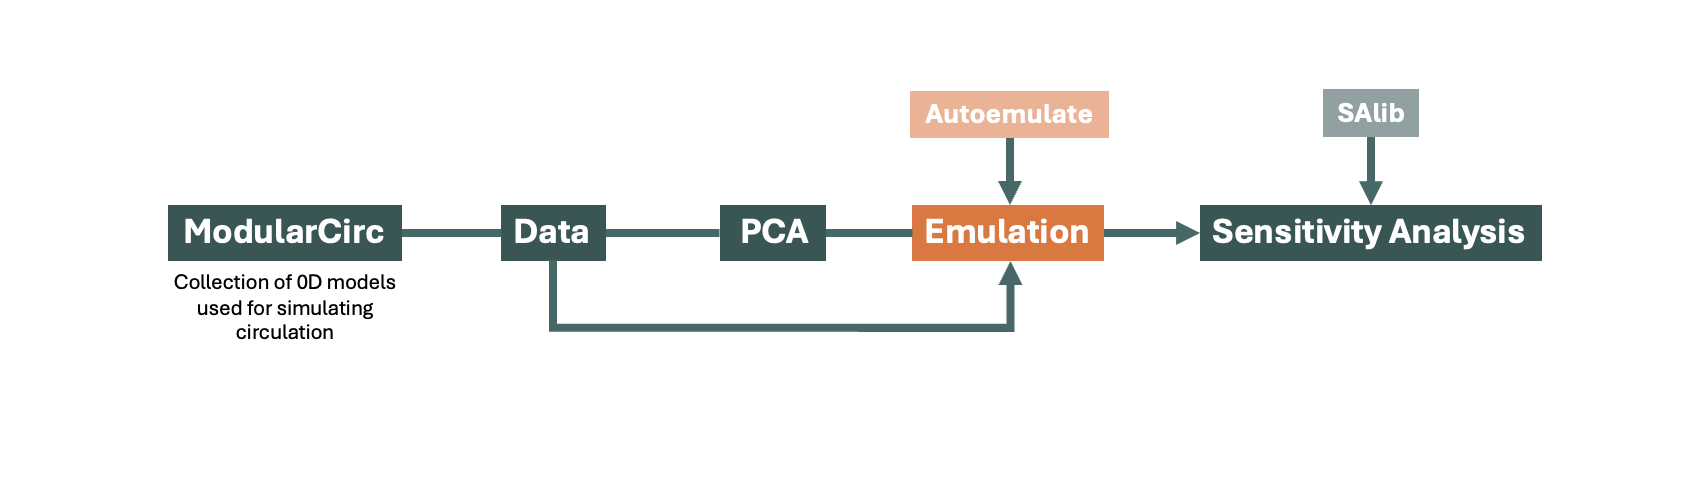

Start by importing the necessary modules
* For using autoemulate on an M1 mac, you need to install lightGBM via conda: `conda install lightgbm`

 * Or install autoemulate using this link: `pip install https://github.com/alan-turing-institute/autoemulate.git@remove-lightgbm`

In [ ]:
%load_ext autoreload 
%autoreload 2
import joblib
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from autoemulate.compare import AutoEmulate
from SALib.sample import saltelli
from SALib.analyze import sobol

!pwd

Specifying the dataset to be used for emulation

In [ ]:
n_runs=500
main_path = os.getcwd()

Load the dataset and pre-trained models (scaler, PCA and reduced PCA), and then match the indices of the PCA-reduced data (y) with the original data (X)

In [ ]:
input_X = f"../Tutorials/data/input/input_parameters_{n_runs}.csv"
x_data_frame = pd.read_csv(input_X, index_col="Index")

relevant_columns = []
for col in x_data_frame.columns:
    relevant_columns.append(col)
    if col == 'T': break

scaler_loaded = joblib.load(f'../Tutorials/data/output_pca_{n_runs}/scaler.pkl')
pca_loaded = joblib.load(f'../Tutorials/data/output_pca_{n_runs}/pca.pkl')

y = pca_loaded

X = x_data_frame[relevant_columns].loc[y.index]

In [ ]:
output_emulation = f'../Tutorials/data/output_emulation_{n_runs}'
os.system(f'mkdir -p {output_emulation}')

Hyperparameter optimisation for each component - currently excluding Gaussian Process

The best emulator for each component will be saved to your files and the results will be printed.

In [ ]:
for i in range(y.shape[1]):
    print(f' Component {i + 1}')
    em = AutoEmulate()
    em.setup(X, y.values[:,i], 
            param_search=True, 
            param_search_type='bayes', 
            param_search_iters=5,
             model_subset=["NeuralNetSk", "SecondOrderPolynomial", "SupportVectorMachines", "GradientBoosting", "RandomForest"],
            #  n_jobs=6
            )
    
    best_model = em.compare()
    em.print_results()
    best_model = em.refit_model(em.best_model)

    em.save_model(best_model, path=f"{output_emulation}/best_emulator_component_{i}")

## Sensitivity Analysis

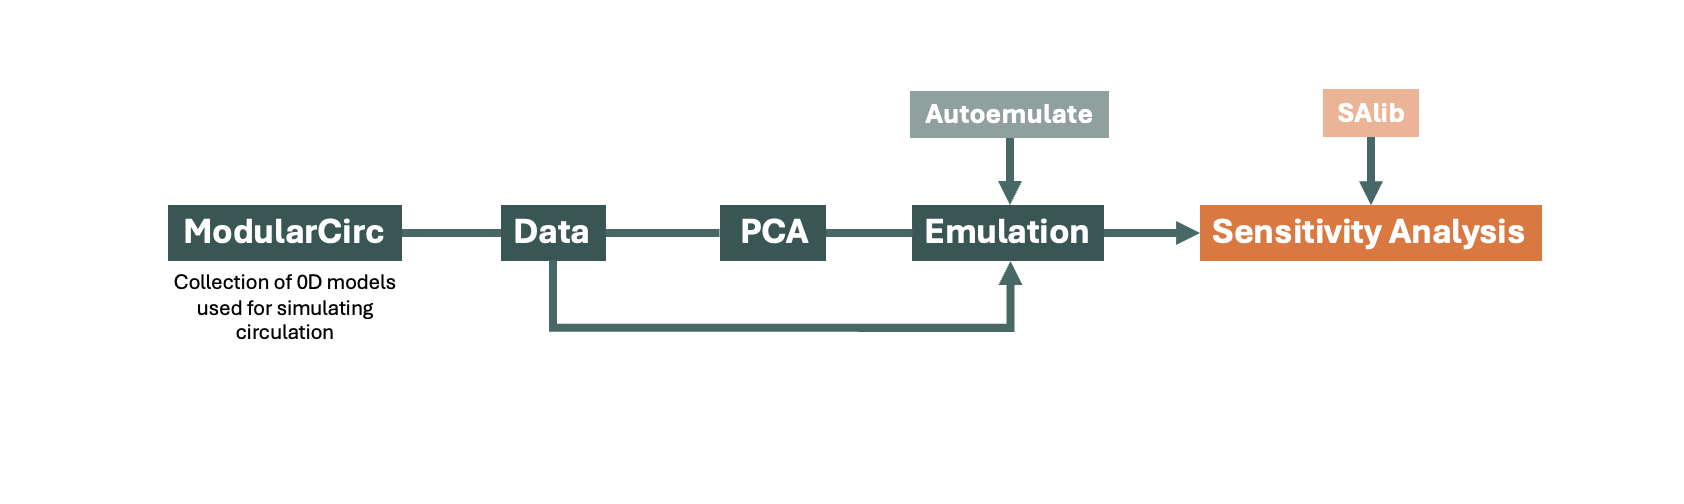

SALib is an open source library written in Python for performing sensitivity analyses.

https://salib.readthedocs.io/en/latest/user_guide/basics.html#what-is-salib 

A typical sensitivity analysis using SALib follows four steps:

1. Determine the model inputs (parameters) and their sample range.

2. Run the sample function to generate the model inputs.

3. Evaluate the model using the generated inputs, saving the model outputs.

4. Run the analyze function on the outputs to compute the sensitivity indices.

First the emulators are loaded, from where they were saved, as well as the orignal input paramter file with a matching number of samples.

In [ ]:
pca1_emulator = joblib.load(f'../Tutorials/data/output_emulation_{n_runs}/best_emulator_component_0')
pca2_emulator = joblib.load(f'../Tutorials/data/output_emulation_{n_runs}/best_emulator_component_1')
pca3_emulator = joblib.load(f'../Tutorials/data/output_emulation_{n_runs}/best_emulator_component_2')
pca4_emulator = joblib.load(f'../Tutorials/data/output_emulation_{n_runs}/best_emulator_component_3')

In [ ]:
input_X = f"../Tutorials/data/input/input_parameters_{n_runs}.csv"
input_data = pd.read_csv(input_X, index_col="Index")

Removing values that are constants or based on constants.

In [ ]:
relevant_columns = []
for col in input_data.columns:
    relevant_columns.append(col)
    if col == 'T': break

Define a `dict` defining the number of inputs, the names of the inputs, and the bounds on each input:

In [ ]:
problem = {
    'num_vars': len(relevant_columns),
    'names': relevant_columns,
    'bounds' : input_data[relevant_columns].describe().loc[['min', 'max']].T.values
}

As we are performing a Sobol sensitivity analysis, we should generate samples using the Saltelli sampler.

In [ ]:
param_values = saltelli.sample(problem, 1024, calc_second_order=True)
param_values.shape

In [ ]:
Y_pca1 = pca1_emulator.predict(param_values)
Y_pca2 = pca2_emulator.predict(param_values)
Y_pca3 = pca3_emulator.predict(param_values)
Y_pca4 = pca4_emulator.predict(param_values)

`sobol.analyze` - will compute first, second, and total-order indices.

In [ ]:
sobol_indices_pca = [
    sobol.analyze(problem, Y_pca1, calc_second_order=True),
    sobol.analyze(problem, Y_pca2, calc_second_order=True),
    sobol.analyze(problem, Y_pca3, calc_second_order=True),
    sobol.analyze(problem, Y_pca4, calc_second_order=True)
]

Here, *S1*, *ST* and *ST* cumulative sum is being calculated and the results are saved to file.

In [ ]:
for i in range(4):
    os.system(f'mkdir -p {main_path}/results/pca{i+1}')

    S1 = pd.DataFrame(sobol_indices_pca[i]['S1'], index=relevant_columns, columns=['S1'])
    S1.sort_values('S1', inplace=True, ascending=False)
    S1.to_csv(f'{main_path}/results/pca{i+1}/s1_{n_runs}.csv')
    
    ST = pd.DataFrame(sobol_indices_pca[i]['ST'], index=relevant_columns, columns=['ST'])
    ST.sort_values('ST', inplace=True, ascending=False)
    ST.to_csv(f'{main_path}/results/pca{i+1}/st_{n_runs}.csv')
    
    ST_cumsum = ST.cumsum() / ST.cumsum().iloc[-1]
    ST_cumsum.to_csv(f'{main_path}/results/pca{i+1}/st_cumsum_{n_runs}.csv')

Pie chart of ST results:

In [ ]:
sobol_indices_pca = sobol.analyze(problem, Y_pca1, calc_second_order=True)

ST = pd.DataFrame(sobol_indices_pca['ST'], index=relevant_columns, columns=['ST'])
ST.sort_values('ST', inplace=True, ascending=False)

labels = ST.index
sizes = ST['ST']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('Sensitivity Analysis Results')
plt.show()

Example of results of sensitivity analysis:

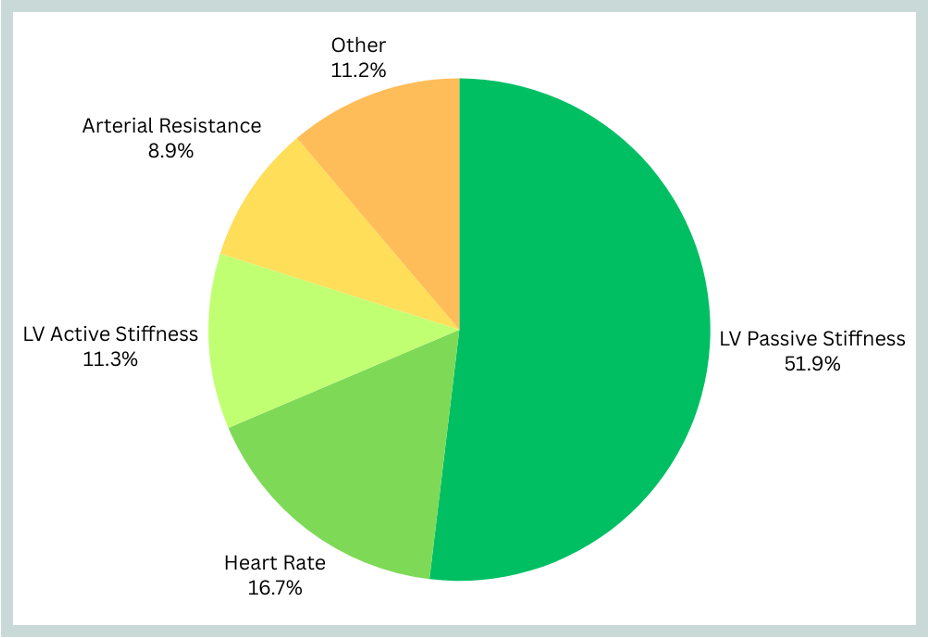

### Using the Results

* This smaller subset of parameters can be better **optimised** to fit to patient data

* This could improve **efficiency** of future research and development of the implantable devices

* Ideally this will eventually lead to **optimised** management of patient
